<a href="https://colab.research.google.com/github/kanzaki-coder/deeplearning/blob/master/weed_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

公開してあるグーグルドライブからファイルをダウンロードします

In [0]:
#グーグルドライブからファイルをダウンロードする方法
#ファイル限定

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    token = get_confirm_token(response)

    if token:

        params = { 'id' : id, 'confirm' : token }

        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):

    for key, value in response.cookies.items():

        if key.startswith('download_warning'):

            return value

    return None

def save_response_content(response, destination):

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:

        for chunk in response.iter_content(CHUNK_SIZE):

            if chunk: # filter out keep-alive new chunks

                f.write(chunk)

#取得されるトークン
file_id = '1krNib7CAe5tqg895BEUvDoG1ujd2WB6q'

#欲しいフォルダ名
destination = 'cluster01.zip'

download_file_from_google_drive(file_id, destination)



In [4]:
#解凍する
!unzip cluster01.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: cluster01/mameasagao/mameasagao_IMG_4440_7.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4440_8.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4440_9.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_1.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_10.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_11.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_12.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_2.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_3.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_4.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_5.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_6.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_7.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_8.JPG  
  inflating: cluster01/mameasagao/mameasagao_IMG_4441_9.JPG  
  inflating: cluster01/mameasagao/m

VGG16というすでに訓練済みのモデルを途中まで利用してモデルを構築します

In [5]:

#ここからファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import VGG16


input_size=224
#input_sizeは224,224までOK。デモ用に数字を150に落としてある。


vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
last = vgg_conv.output


vgg_conv.trainable = True

set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


mod = Flatten()(last)
mod = Dense(256, activation='relu')(mod)
#mod = Dropout(0.5)(mod)
preds = Dense(10, activation='softmax')(mod)

model = models.Model(vgg_conv.input, preds)

model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
'''
参考URL
https://qiita.com/T_Tao/items/0e869e440067518b6b58#grad-cam%E3%81%AE%E5%AE%9F%E8%A3%85
'''

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

'\n参考URL\nhttps://qiita.com/T_Tao/items/0e869e440067518b6b58#grad-cam%E3%81%AE%E5%AE%9F%E8%A3%85\n'

解凍したファイルをそれぞれ訓練データと検証用のデータに分けます

In [6]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image


#clsdir = "/content/deeplearning/weed_type"

clsdir = "/content/cluster01"



datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            validation_split = 0.2,
            rescale=1./255
        )
#validation_splitでtrainとvalidationの比率を変更できる。


train_generator=datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
        )

validation_generator = datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
        )

Found 9182 images belonging to 10 classes.
Found 2292 images belonging to 10 classes.


モデルを実行して画像を学習させていきます

In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

#epochsを必要な長さに応じて変更

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
100/100 [==============================] - 42s 423ms/step - loss: 1.8699 - acc: 0.3560 - val_loss: 1.7069 - val_acc: 0.3880
Epoch 2/30
100/100 [==============================] - 36s 357ms/step - loss: 1.3482 - acc: 0.5290 - val_loss: 1.5198 - val_acc: 0.4420
Epoch 3/30
100/100 [==============================] - 36s 362ms/step - loss: 1.0814 - acc: 0.6220 - val_loss: 1.3553 - val_acc: 0.4919
Epoch 4/30
100/100 [==============================] - 36s 361ms/step - loss: 0.8709 - acc: 0.7050 - val_loss: 1.2222 - val_acc: 0.5580
Epoch 5/30
100/100 [==============================] - 35s 353ms/step - loss: 0.8264 - acc: 0.7080 - val_loss: 1.2572 - val_acc: 0.5323
Epoch 6/30
100/100 [==============================] - 36s 356ms/step - loss: 0.6789 - acc: 0.7770 - val_loss: 1.1146 - val_acc: 0.5750
Epoch 7/30
100/100 [==============================] - 36s 362ms/step - loss: 0.6627 - acc: 0.7

正解率と損失率をグラフ化します

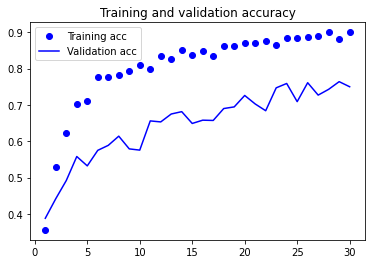

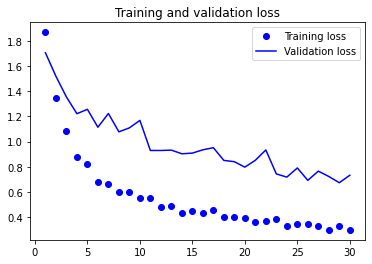

In [8]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [0]:
#モデルを保存するなら⇒gradcamのための保存
from keras.models import load_model
model.save('weed_type.h5')
model=load_model('weed_type.h5')


以上でデモンストレーションは終了です。